In [1]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as spf
from pyspark.sql.types import *

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()

In [3]:
data = spark.read.json("/user/anokhin/seminar-2/*/data.json").withColumn("rnd", spf.rand())

data.printSchema()

root
 |-- experiments: struct (nullable = true)
 |    |-- STICKY_ARTIST: string (nullable = true)
 |-- latency: double (nullable = true)
 |-- message: string (nullable = true)
 |-- recommendation: long (nullable = true)
 |-- time: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- track: long (nullable = true)
 |-- user: long (nullable = true)
 |-- rnd: double (nullable = false)



In [4]:
data.count()

384709

In [7]:
data.show(3, False)

+-----------+---------------------+-------+--------------+----+-------------+-----+----+-------------------+
|experiments|latency              |message|recommendation|time|timestamp    |track|user|rnd                |
+-----------+---------------------+-------+--------------+----+-------------+-----+----+-------------------+
|[T1]       |0.01097559928894043  |next   |47055         |1.0 |1727289551284|47055|4298|0.28281619238416467|
|[C]        |0.0016002655029296875|next   |48100         |0.64|1727289551292|45208|4670|0.12017669958406985|
|[C]        |0.0013813972473144531|next   |39136         |0.0 |1727289551310|39136|786 |0.8604588701827581 |
+-----------+---------------------+-------+--------------+----+-------------+-----+----+-------------------+
only showing top 3 rows



In [6]:
tracks = spark.read.json("/user/anokhin/tracks.json").toPandas()

tracks.sort_values("pop", ascending=False).head(3)

,album,artist,duration,genre,pop,title,track
20424,Дарите женщинам цветы,Jazzdauren,178,[1],5.139291,Дарите женщинам цветы,3826
3904,Матушка,Татьяна Куртукова,173,[1],4.617107,Матушка,12151
49975,Чёрная смородина,SEVENROSE,232,[1],4.404717,Чёрная смородина,16149


## Compute track popularity

In [7]:
track_popularity = (
    data
        .filter(spf.col("rnd") > 0.5)
        .groupBy(
            spf.col("track")
        )
        .agg(
            spf.sum(spf.col("time")).alias("popularity")
        )
        .toPandas()
        .sort_values("popularity", ascending=False)
        .reset_index(drop=True)
)

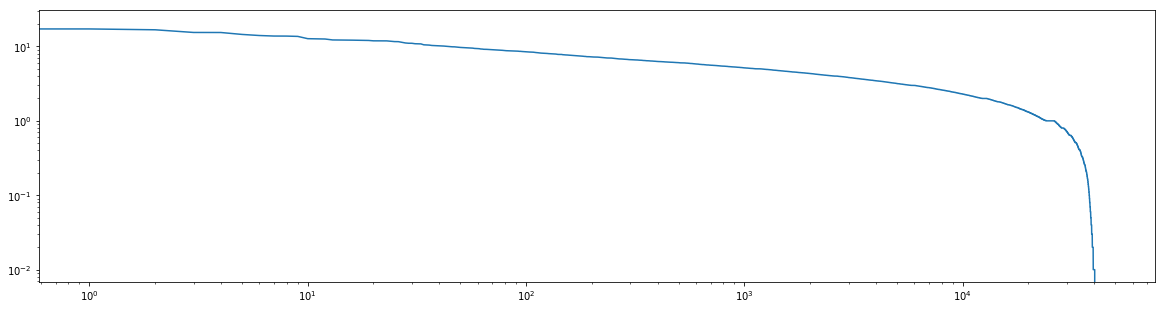

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["popularity"].values)

ax.set_xscale("log")
ax.set_yscale("log")

In [10]:
(
    pd.merge(track_popularity, tracks, on="track")
#         .sort_values("pop", ascending=False)
        .head(10)
)

,track,popularity,album,artist,duration,genre,pop,title
0,28549,20.95,Ялгыз Торна,Фирдус Тямаев,243,[1],0.128325,Ялгыз Торна
1,18295,17.19,Menda qolmadi dil,Jaloliddin Ahmadaliyev,308,"[81, 1]",-0.277881,Menda qolmadi dil
2,32649,16.75,"BTS, THE BEST",BTS,223,"[152, 10]",-0.018736,IDOL (Japanese ver.)
3,8957,15.42,Seven Mix,DJ Seven,86,[6],-1.259838,Walking Chance
4,40708,15.40,Бэхет сере,Анвар Нургалиев,212,[1],0.046881,Сон дисенме микэн
5,44708,14.51,Skool Luv Affair (Special Addition),BTS,236,[152],-0.287483,Jump
6,32301,14.03,Sorry,Miyagi,194,[10],0.129749,Sorry
7,13085,13.80,Impossible,RILTIM,213,"[53, 6, 36]",-0.214414,Someday
8,8808,13.78,Tox Tani Tani,Ernest Ogannesyan,159,[1],-0.703874,Tox Tani Tani
9,32776,13.65,Falling In Love,Dani Corbalan,227,[36],-0.747872,Falling In Love (Radio Edit)


## Compute offline metrics

In [14]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [15]:
tracks = track_popularity["track"].tolist()

t_p_10_udf = spf.udf(lambda track: precision_at(tracks, track, 10))
st_10_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:10], track, 10))
st_100_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:100], track, 10))
st_1000_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:1000], track, 10))


metrics = (
    data
        .filter(spf.col("rnd") <= 0.5)
        .filter(spf.col("time") >= 0.8)
        .select(
            t_p_10_udf(spf.col("track")).alias("t_p_10_udf"),
            st_10_p_10_udf(spf.col("track")).alias("st_10_p_10_udf"),
            st_100_p_10_udf(spf.col("track")).alias("st_100_p_10_udf"),
            st_1000_p_10_udf(spf.col("track")).alias("st_1000_p_10_udf")
        )
)

In [16]:
metrics.describe().toPandas()

,summary,t_p_10_udf,st_10_p_10_udf,st_100_p_10_udf,st_1000_p_10_udf
0,count,37094,37094,37094,37094
1,mean,2.722812314660052E-4,2.722812314660052E-4,1.5635951905968628E-4,7.278805197606083E-5
2,stddev,0.005211018914673617,0.005211018914673617,0.003951192792236779,0.002696980382853694
3,min,0.0,0.0,0.0,0.0
4,max,0.1,0.1,0.1,0.1


## Export data for prod

In [17]:
with open("/home/anokhin/top_tracks.json", "w") as top_tracks_file:
    json.dump(tracks, top_tracks_file)